In [1]:
import initialize
settings = initialize.Settings()
# Generate plot of raw data and ask if ready to start processing =========
try:
    print('Probing data "%s"...' % settings.fileName)
    # settings.probeData()
    # settings.probeData('C:/Repository/SoftGNSS-python/GNSS_signal_records/GPSdata-DiscreteComponents-fs38_192-if9_55.bin')
finally:
    pass
print('  Raw IF data plotted ')
print('  (run setSettings or change settings in "initialize.py" to reconfigure)')
print(' ')
gnssStart = True

Probing data "C:/Repository/SoftGNSS-python/GNSS_signal_records/GPSdata-DiscreteComponents-fs38_192-if9_55.bin"...
  Raw IF data plotted 
  (run setSettings or change settings in "initialize.py" to reconfigure)
 


In [2]:
import matplotlib.pyplot as plt # type: ignore
from scipy.signal import welch # type: ignore
from scipy.signal.windows import hamming # type: ignore
import datetime
import numpy as np # type: ignore
fileNameStr='C:\Repository\Scripts_general\SoftGNSS-python\GNSS_signal_records\GPSdata-DiscreteComponents-fs38_192-if9_55.bin'

# Check the number of arguments ==========================================
if fileNameStr is None:
    # fileNameStr = self.fileName
    if not isinstance(fileNameStr, str):
         raise TypeError('File name must be a string')


In [3]:
# Processing settings ====================================================
# Number of milliseconds to be processed used 36000 + any transients 
# (see # below - in Nav parameters) to ensure nav subframes are provided
settings.msToProcess = 37000.0
# Number of channels to be used for signal processing
settings.numberOfChannels = 8
# # Move the starting point of processing. Can be used to start the signal
# # processing at any point in the data record (e.g. for long records). 
# fseek function is used to move the file read point, therefore advance is byte based only.
settings.skipNumberOfBytes = 0
# Raw signal file name and other parameter ===============================
# This is a "default" name of the data file (signal record) to be used in
# the post-processing mode
settings.fileName = 'C:\Repository\Scripts_general\SoftGNSS-python\GNSS_signal_records\GPSdata-DiscreteComponents-fs38_192-if9_55.bin'
# Data type used to store one sample
settings.dataType = 'int8'
# Intermediate, sampling and code frequencies
settings.IF = 9548000.0
settings.samplingFreq = 38192000.0
settings.codeFreqBasis = 1023000.0
# Define number of chips in a code period
settings.codeLength = 1023
# Acquisition settings ===================================================
# Skips acquisition in the script postProcessing.m if set to 1
settings.skipAcquisition = False
# List of satellites to look for. Some satellites can be excluded to speed
# up acquisition
settings.acqSatelliteList = range(1, 33)
# Band around IF to search for satellite signal. Depends on max Doppler
settings.acqSearchBand = 14.0
# Threshold for the signal presence decision rule
settings.acqThreshold = 2.5
# Tracking loops settings ================================================
# Code tracking loop parameters
settings.dllDampingRatio = 0.7
settings.dllNoiseBandwidth = 2.0
settings.dllCorrelatorSpacing = 0.5
# Carrier tracking loop parameters
settings.pllDampingRatio = 0.7
settings.pllNoiseBandwidth = 25.0
# Navigation solution settings ===========================================
# Period for calculating pseudoranges and position
settings.navSolPeriod = 500.0
# Elevation mask to exclude signals from satellites at low elevation
settings.elevationMask = 10.0
# # Enable/dissable use of tropospheric correction
settings.useTropCorr = True
# 1 - On
# True position of the antenna in UTM system (if known). Otherwise enter
# all NaN's and mean position will be used as a reference .
# settings.truePosition = TruePosition()
# settings.truePosition.E = np.nan
# settings.truePosition.N = np.nan
# settings.truePosition.U = np.nan
# # Plot settings ==========================================================
# # Enable/disable plotting of the tracking results for each channel
settings.plotTracking = True
# 1 - On
# Constants ==============================================================
settings._c = 299792458.0
settings._startOffset = 68.802

In [4]:
try:
        with open(fileNameStr, 'rb') as fid:
                fid.seek(settings.skipNumberOfBytes, 0)
                samplesPerCode = settings.samplesPerCode
                try:
                        data = np.fromfile(fid, settings.dataType, 10 * samplesPerCode)
                except IOError:
                    # The file is too short
                    print('Could not read enough data from the data file.')
except IOError as e:
        print('Unable to read file "%s": %s' % (fileNameStr, e))

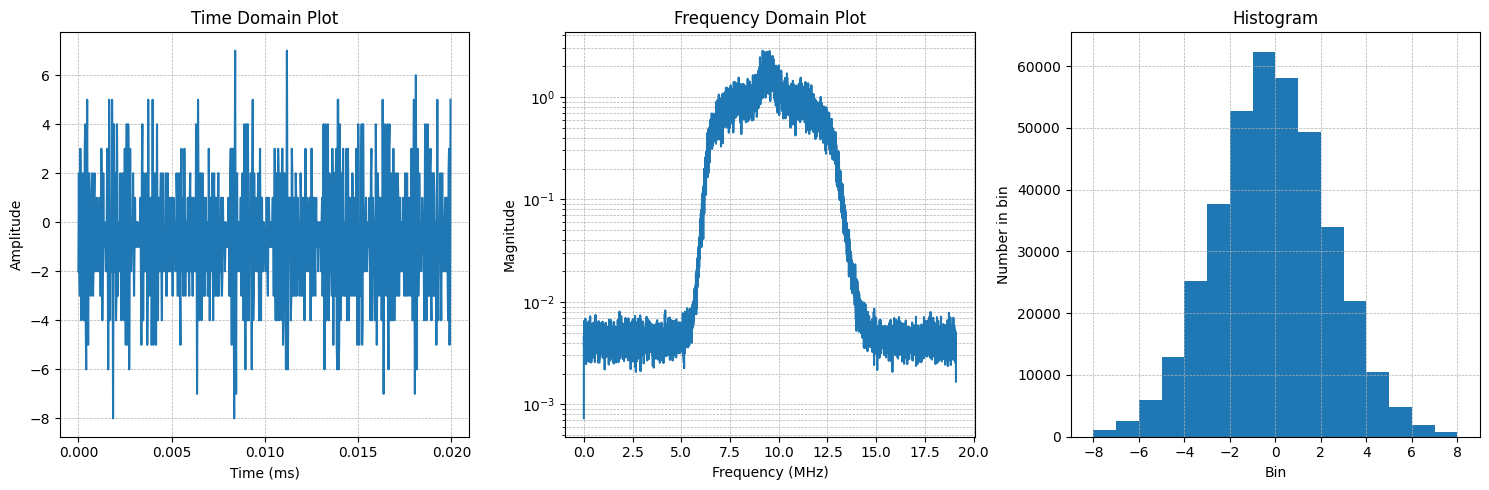

In [5]:
timeScale = np.arange(0, 0.05, 1 / settings.samplingFreq) # type: ignore

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Primeiro subplot: Domínio do Tempo
axs[0].plot(1000 * timeScale[:int(samplesPerCode / 50)], data[:int(samplesPerCode / 50)])
axs[0].set_title('Time Domain Plot')
axs[0].set_xlabel('Time (ms)')
axs[0].set_ylabel('Amplitude')
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.3f}'))
axs[0].set_xticks(np.arange(0, 0.025, 0.005)) # type: ignore

# Segundo subplot: Domínio da Frequência
f, Pxx = welch(data - np.mean(data), settings.samplingFreq / 1e6, hamming(16384, False), 16384, 1024, 16384) # type: ignore
axs[1].semilogy(f, Pxx)
axs[1].set_title('Frequency Domain Plot')
axs[1].set_xlabel('Frequency (MHz)')
axs[1].set_ylabel('Magnitude')
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Terceiro subplot: Histograma
dmax = np.max(np.abs(data)) + 1 # type: ignore
axs[2].hist(data, bins=np.arange(-128, 128))
axs[2].set_title('Histogram')
axs[2].set_xlabel('Bin')
axs[2].set_ylabel('Number in bin')
axs[2].set_xlim([-dmax, dmax])
axs[2].grid(True, which='both', linestyle='--', linewidth=0.5)

# Ajustar layout
plt.tight_layout()
plt.show()

In [6]:
import acquisition
import postNavigation
import tracking
print('Starting processing...')


Importing functions from ./geoFunctions/
Starting processing...


In [7]:
if not fileNameStr:
    fileNameStr = settings.fileName
if not isinstance(fileNameStr, str):
    raise TypeError('File name must be a string')

In [8]:
with open(fileNameStr, 'rb') as fid:
    fid.seek(settings.skipNumberOfBytes, 0)
    if not settings.skipAcquisition:  # or 'acqResults' not in globals():
    # Find number of samples per spreading code
        samplesPerCode = settings.samplesPerCode
        # frequency estimation
        data = np.fromfile(fid, settings.dataType, 11 * samplesPerCode) # type: ignore
        print('   Acquiring satellites...')
        acqResults = acquisition.AcquisitionResult(settings)
        acqResults.acquire(data)

   Acquiring satellites...
. 
. 
03 
. 
. 
06 
. 
. 
09 
. 
. 
. 
. 
. 
15 
. 
. 
18 
. 
. 
21 
22 
. 
. 
. 
26 
. 
. 
. 
. 
. 
. 


In [25]:
settings.resamplingflag

AttributeError: 'Settings' object has no attribute 'resamplingflag'

   Acquiring satellites...
. 
. 
03 
. 
. 
06 
. 
. 
09 
. 
. 
. 
. 
. 
15 
. 
. 
18 
. 
. 
21 
22 
. 
. 
. 
26 
. 
. 
. 
. 
. 
. 

*=========*=====*===============*===========*=============*========*
| Channel | PRN |   Frequency   |  Doppler  | Code Offset | Status |
*=========*=====*===============*===========*=============*========*
|       0 |  21 |  9.54743e+06 |    -574   |     13403   |     T  |
|       1 |  22 |  9.54969e+06 |    1694   |      6287   |     T  |
|       2 |  15 |  9.54992e+06 |    1921   |     36320   |     T  |
|       3 |  18 |  9.54825e+06 |     246   |     20723   |     T  |
|       4 |  26 |  9.54501e+06 |   -2987   |     26826   |     T  |
|       5 |   6 |  9.54431e+06 |   -3688   |     28201   |     T  |
|       6 |   9 |  9.55083e+06 |    2832   |      4695   |     T  |
|       7 |   3 |  9.54990e+06 |    1903   |     34211   |     T  |
*=========*=====*===============*===========*=============*========*

   Tracking started at 06:47:25
   Tracking is 

c:\Repository\Scripts_general\SoftGNSS-python\postNavigation.py:450: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


Post processing of the signal is over.


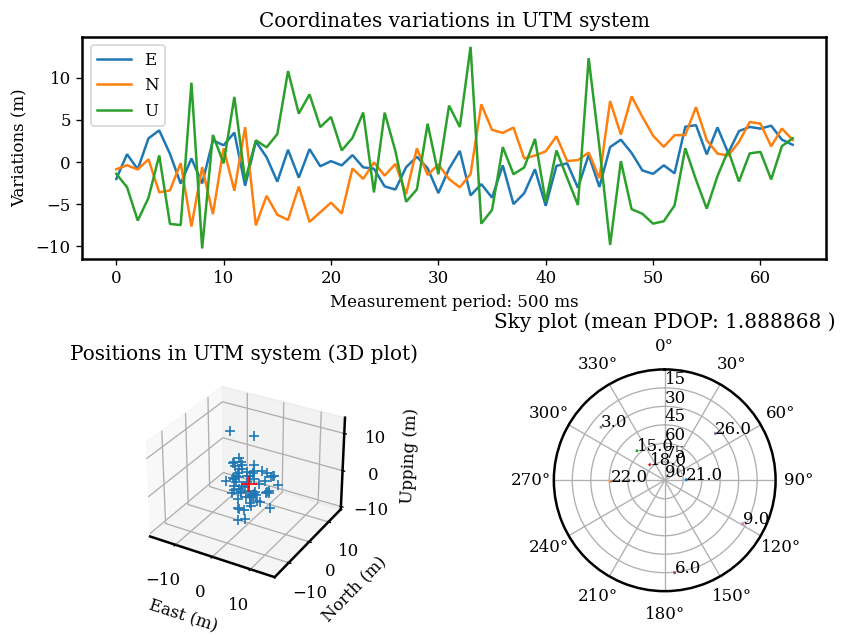

In [10]:
try:
    with open(fileNameStr, 'rb') as fid:
        # If success, then process the data
        # Move the starting point of processing. Can be used to start the
        # signal processing at any point in the data record (e.g. good for long
        # records or for signal processing in blocks).
        fid.seek(settings.skipNumberOfBytes, 0)
        # Acquisition ============================================================
        # Do acquisition if it is not disabled in settings or if the variable acqResults does not exist.
        if not settings.skipAcquisition:  # or 'acqResults' not in globals():
            # Find number of samples per spreading code
            samplesPerCode = settings.samplesPerCode
            # frequency estimation
            data = np.fromfile(fid, settings.dataType, 11 * samplesPerCode) # type: ignore
            print('   Acquiring satellites...')
            acqResults = acquisition.AcquisitionResult(settings)
            acqResults.acquire(data)
            # acqResults.plot()
        # Initialize channels and prepare for the run ============================
        # Start further processing only if a GNSS signal was acquired (the
        # field FREQUENCY will be set to 0 for all not acquired signals)
        if np.any(acqResults.carrFreq): # type: ignore
            acqResults.preRun()
            acqResults.showChannelStatus()
        else:
            # No satellites to track, exit
            print('No GNSS signals detected, signal processing finished.')
            trackResults = None

        # Track the signal =======================================================
        startTime = datetime.datetime.now()
        print('   Tracking started at %s' % startTime.strftime('%X'))
        trackResults = tracking.TrackingResult(acqResults)
        try:
            # trackResults.results = np.load('trackingResults_python.npy')
            trackResults.results = np.load('trackingResults_python.npy', allow_pickle=True)
        except IOError:
            trackResults.track(fid)
            np.save('trackingResults_python', trackResults.results)

        print('   Tracking is over (elapsed time %s s)' % (datetime.datetime.now() - startTime).total_seconds())
        # Auto save the acquisition & tracking results to save time.
        print('   Saving Acquisition & Tracking results to storage')
        # Calculate navigation solutions =========================================
        print('   Calculating navigation solutions...')
        navResults = postNavigation.NavigationResult(trackResults)
        navResults.postNavigate()

        print('   Processing is complete for this data block')
        # Plot all results ===================================================
        print('   Plotting results...')
        # TODO turn off tracking plots for now
        if not settings.plotTracking:
            trackResults.plot()
        navResults.plot()
        print('Post processing of the signal is over.')
except IOError as e:
    # Error while opening the data file.
    print('Unable to read file "%s": %s.' % (settings.fileName, e))


In [ ]:
if gnssStart:
    print(' ')
    settings.postProcessing()